In [2]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import typing as ty

classical_electron_radius = 2.81794032e-15  # [m]
elec_rest_energy = 8.1871057880e-14  # [J]
MeV = 1.6022e-13  # [J]
barn = 1e-28  # [m2]
millimeter = 0.001 # [m]
mol = 6.021e23  # [/mol]
alpha = 1/137
speed_of_light = 299792458
hbar = 1.054571817e-34

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
#### PRELUDE ####

# -------- CALCULUS -------- #


def d_(x: npt.NDArray) -> npt.NDArray:
    return x[1] - x[0]


def dsolid_dangle(a: npt.NDArray) -> npt.NDArray:
    return 2 * np.pi * np.sin(a)


def dsolid_dspherical(a: npt.NDArray) -> npt.NDArray:
    return np.sin(a)


# -------- PROBABILITY DISTRIBUTIONS -------- #


# [i], [j], [i, j, ..] -> [i, ..]
def interp2(x: npt.ArrayLike, xp: npt.ArrayLike, fp: npt.ArrayLike) -> npt.NDArray:
    # https://stackoverflow.com/questions/43772218/fastest-way-to-use-numpy-interp-on-a-2-d-array
    x = np.array(x)
    xp = np.array(xp)
    fp = np.array(fp)
    i = np.arange(x.size)
    j = np.clip(np.searchsorted(xp, x) - 1, a_min=0, a_max=xp.size - 2)
    d = np.clip((x - xp[j]) / (xp[j + 1] - xp[j]), 0, 1)
    if len(fp.shape) > 2:
        axes = np.array(range(len(fp.shape) - 1))
        axes[[0, -1]] = axes[[-1, 0]]
        return np.transpose(
            (1 - d) * np.transpose(fp[i, j], axes=axes)
            + np.transpose(fp[i, j + 1], axes=axes) * d,
            axes=axes,
        )
    else:
        return (1 - d) * fp[i, j] + fp[i, j + 1] * d


# [i], [j], [j, ..] -> [i, ..]
def interpx(x: npt.ArrayLike, xp: npt.ArrayLike, fp: npt.ArrayLike) -> npt.NDArray:
    # https://stackoverflow.com/questions/43772218/fastest-way-to-use-numpy-interp-on-a-2-d-array
    x = np.array(x)
    xp = np.array(xp)
    fp = np.array(fp)
    j = np.clip(np.searchsorted(xp, x) - 1, a_min=0, a_max=xp.size - 2)
    d = np.clip((x - xp[j]) / (xp[j + 1] - xp[j]), 0, 1)
    if len(fp.shape) > 1:
        axes = np.array(range(len(fp.shape)))
        axes[[0, -1]] = axes[[-1, 0]]
        return np.transpose(
            (1 - d) * np.transpose(fp[j], axes=axes)
            + np.transpose(fp[j + 1], axes=axes) * d,
            axes=axes,
        )
    else:
        return (1 - d) * fp[j] + fp[j + 1] * d


# [count, dist_len]
def sample_dists(
    dists: npt.NDArray, out_range: npt.NDArray | None = None
) -> npt.NDArray:
    if out_range is None:
        out_range = np.arange(dists.shape[1])
    return np.array([np.interp(np.random.random(), dist, out_range) for dist in dists])


def normalize_axis(x_in: npt.ArrayLike, axis: int) -> npt.NDArray:
    x = np.array(x_in)
    axes = np.array(range(len(x.shape)))
    axes[[0, axis]] = axes[[axis, 0]]

    x = x.transpose(axes)
    x -= x[0]
    return np.transpose(x / x[-1], axes=axes)


Distr_1_2 = tuple[npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray]


def prep_distr_1_2(
    dist: npt.NDArray,  # [arg_axis, distr_axis_0, distr_axis_1]
    arg_range: npt.NDArray,  # [arg_axis]
    distr_axis_0_range: npt.NDArray,  # [distr_axis_0]
    distr_axis_1_range: npt.NDArray,  # [distr_axis_1]
) -> Distr_1_2:
    dist_0 = normalize_axis(np.cumsum(dist.sum(axis=(2,)), axis=1), axis=1)
    dist_1 = normalize_axis(dist.cumsum(axis=2), axis=2)
    return dist_0, dist_1, arg_range, distr_axis_0_range, distr_axis_1_range


def sample_distr_1_2(
    count: int,
    dist_1_2: Distr_1_2,
    argument: float,
) -> tuple[npt.NDArray, npt.NDArray]:
    dist_0, dist_1, arg_range, distr_axis_0_range, distr_axis_1_range = dist_1_2

    dist_0_interpolated: npt.NDArray = interpx(
        [argument],
        arg_range,
        dist_0,
    )[0]
    x0 = np.interp(
        np.random.random(count),
        dist_0_interpolated,
        distr_axis_0_range,
    )
    dist_1_interpolated = interpx(
        x0,
        distr_axis_0_range,
        interpx([argument], arg_range, dist_1)[0],
    )
    x1 = sample_dists(dist_1_interpolated, out_range=distr_axis_1_range)
    return x0, x1


Distr_1_1 = tuple[npt.NDArray, npt.NDArray, npt.NDArray]


def prep_distr_1_1(
    dist: npt.NDArray,  # [arg_axis, distr_axis_0]
    arg_range: npt.NDArray,  # [arg_axis]
    distr_axis_0_range: npt.NDArray,  # [distr_axis_0]
) -> Distr_1_1:
    return (
        normalize_axis(np.cumsum(dist, axis=1), axis=1),
        arg_range,
        distr_axis_0_range,
    )


def sample_distr_1_1(
    count: int,
    dist: Distr_1_1,
    argument: float,
) -> npt.NDArray:
    dist_0, arg_range, distr_axis_0_range = dist
    dist_interpolated: npt.NDArray = interpx(
        [argument],
        arg_range,
        dist_0,
    )[0]
    x0 = np.interp(
        np.random.random(count),
        dist_interpolated,
        distr_axis_0_range,
    )
    return x0


def random_partition(rel_probabilities: npt.ArrayLike, count: int) -> ty.Iterable[int]:
    random_vals = np.random.random(count)
    distr = np.cumsum(rel_probabilities)
    distr /= distr[-1]
    return np.diff([0] + [np.sum(random_vals < threshold) for threshold in distr])

In [4]:
# ( [energy/J; n], [stopping_power/(J/m); n] )
SRXMData = tuple[npt.NDArray,npt.NDArray]

# ( [theta/rad; n], [energy/J; n] )
AngleEnergy = tuple[npt.NDArray,npt.NDArray]

# (phot_energy/J) -> cross_section_density/(/m)
CrossSectionFnTotal = ty.Callable[[float],float]
# (n_rays:int, phot_energy/J) -> electrons:AngleEnergy
CrossSectionFnGenrays = ty.Callable[[int,float], AngleEnergy]
CrossSection = tuple[CrossSectionFnTotal,CrossSectionFnGenrays]

Foil = tuple[SRXMData,list[CrossSection]]

In [5]:
def srxm_attenuate(
    energy_in: npt.ArrayLike, depth_in: npt.ArrayLike, srxm: SRXMData, N=1000
) -> npt.NDArray:
    energy = np.array(energy_in)
    depth = np.array(depth_in)
    dx = depth / N
    for _ in range(N):
        stopping_power = np.interp(energy, srxm[0], srxm[1])
        energy -= stopping_power * dx
    energy[energy < srxm[0][0]] = 0
    return energy

In [6]:
def foil_trace(
    n_steps: int,
    n_rays_incident: int,
    n_srxm_steps: int,
    phot_energy_in: float,
    foil_properties: Foil,
    foil_depth: float,
) -> AngleEnergy:
    dx = foil_depth / n_steps

    srxm, cross_sections = foil_properties

    cross_section_density_totals = [
        cross_section[0](phot_energy_in) for cross_section in cross_sections
    ]
    step_interaction_probability_total = 1 - np.exp(
        -np.sum(cross_section_density_totals) * dx
    )

    elec_angles_out: list[npt.NDArray] = []
    elec_energies_out: list[npt.NDArray] = []
    n_rays = n_rays_incident
    for x in np.linspace(0, foil_depth - dx, n_steps):
        n_rays_interacting = np.sum(
            np.random.random(n_rays) < step_interaction_probability_total
        )
        n_rays -= n_rays_interacting
        process_interaction_counts = random_partition(
            cross_section_density_totals, n_rays_interacting
        )
        for cross_section, count in zip(cross_sections, process_interaction_counts):
            elec_angle, elec_energy = cross_section[1](count, phot_energy_in)
            depth = (x + dx * np.random.random(elec_angle.shape)) / np.cos(elec_angle)
            elec_energy = srxm_attenuate(elec_energy, depth, srxm, n_srxm_steps)
            elec_angles_out.append(elec_angle)
            elec_energies_out.append(elec_energy)

    return np.concat(elec_angles_out), np.concat(elec_energies_out)

In [7]:
VB = []
VC = []
def gen_cross_section_compton(
    electron_number_density: float,  # electrons/m^3
    phot_energy_range: npt.NDArray,  # :: [energy/J; n]
    phot_out_angle_range: npt.NDArray,  # :: [angle/rad; m]
) -> CrossSection:
    # /m
    def csd_total(energy_in: npt.NDArray) -> npt.NDArray:
        s0 = 6.651e-29  # m2
        a0 = energy_in / elec_rest_energy
        return s0 * 3 / 8 / a0 * (np.log(2 * a0) + 0.5) * electron_number_density

    # /m /st
    def csd_differential(
        energy_in: npt.NDArray, phot_angle_out: npt.NDArray
    ) -> npt.NDArray:
        alpha_0 = energy_in / elec_rest_energy
        cos_theta = np.cos(phot_angle_out)
        return (
            classical_electron_radius**2
            * (1 + cos_theta**2)
            / (1 + alpha_0 * (1 - cos_theta)) ** 2
            * (
                1
                + (alpha_0**2 * (1 - cos_theta) ** 2)
                / ((1 + cos_theta**2) * (1 + alpha_0 * (1 - cos_theta)))
            )
        ) * electron_number_density

    def compton_elec_params(
        phot_energy_in: npt.NDArray, phot_angle_out: npt.NDArray
    ) -> tuple[
        npt.NDArray,  # elec_energy_out
        npt.NDArray,  # elec_angle_out
    ]:
        a_0 = phot_energy_in / elec_rest_energy
        a = a_0 / (1 + a_0 * (1 - np.cos(phot_angle_out)))
        elec_energy_out = (a_0 - a) * elec_rest_energy
        elec_angle_out = np.arctan(1 / ((a_0 + 1)*np.tan(phot_angle_out/2))) #* np.sqrt((2 * a_0 * a) / (a_0 - a) - 1)
        return elec_angle_out, elec_energy_out

    phot_scattering_angle_distr = prep_distr_1_1(
        csd_differential(
            np.expand_dims(phot_energy_range, axis=1).repeat(
                phot_out_angle_range.size, axis=1
            ),
            np.expand_dims(phot_out_angle_range, axis=0).repeat(
                phot_energy_range.size, axis=0
            ),
        ),
        phot_energy_range,
        phot_out_angle_range,
    )

    def gen_rays(count: int, phot_energy_in: float) -> AngleEnergy:
        phot_angle_out = sample_distr_1_1(
            count, phot_scattering_angle_distr, phot_energy_in
        )
        VB.append(phot_angle_out)
        VC.append(compton_elec_params(phot_energy_in, phot_angle_out)[0])
        return compton_elec_params(phot_energy_in, phot_angle_out)

    return csd_total, gen_rays

In [91]:
import time

PairProductionRawCrossSection = tuple[
    npt.NDArray, tuple[npt.NDArray, npt.NDArray, npt.NDArray]
]


def calculate_pairproduction_cross_section(
    Z: int,
    energy_gamma: npt.NDArray,  # [J]
    energy_elec_frac: npt.NDArray,  # [1]
    angle_posi: npt.NDArray,  # [rad]
    angle_elec: npt.NDArray,  # [rad]
    angle_inter: npt.NDArray,  # [rad]
) -> PairProductionRawCrossSection:

    def genarg(arg: npt.NDArray, axis: int) -> npt.NDArray:
        axes = {0, 1} - {axis}
        arg = np.expand_dims(arg, axis=tuple(axes))
        for axis_i, size in [
            (i, x.size) for i, x in enumerate([angle_posi, angle_inter]) if i in axes
        ]:
            arg = arg.repeat(size, axis=axis_i)
        return arg

    d_energy_elec_frac = d_(energy_elec_frac)
    d_angle_posi = d_(angle_posi)
    d_angle_elec = d_(angle_elec)
    d_angle_inter = d_(angle_inter)

    d_sigma_for_elec = np.zeros(
        (energy_gamma.size, energy_elec_frac.size, angle_elec.size)
    )

    n_done = 0
    t_next_update = time.time() + 1
    t_next_update_delay = 1
    t_start = time.time()
    for i_energy_gamma, i_energy_elec_frac, i_angle_elec in (
        (i_energy_gamma, i_energy_elec_frac, i_angle_elec)
        for i_energy_gamma in range(energy_gamma.size)
        for i_energy_elec_frac in range(energy_elec_frac.size)
        for i_angle_elec in range(angle_elec.size)
    ):

        energy_gamma_ = energy_gamma[i_energy_gamma]
        energy_elec_ = (
            energy_elec_frac[i_energy_elec_frac]
            * (energy_gamma_ - (elec_rest_energy * 1.001) * 2)
            + elec_rest_energy * 1.0001
        )
        angle_posi_ = genarg(angle_posi, 0)
        angle_elec_ = angle_elec[i_angle_elec]
        angle_inter_ = genarg(angle_inter, 1)

        d_energy_elec = d_energy_elec_frac * (
            energy_gamma_ - (elec_rest_energy * 1.001) * 2
        )

        # E^2 = m^2 c^4 + p^2 c^2
        # p^2 = (E^2 - E_rest^2)/c^2
        Ey = energy_gamma_
        En = energy_elec_
        Ep = energy_gamma_ - energy_elec_
        pn2 = ((En**2) - (elec_rest_energy**2)) / (speed_of_light**2)
        pp2 = ((Ep**2) - (elec_rest_energy**2)) / (speed_of_light**2)
        pn = np.sqrt(pn2)
        pp = np.sqrt(pp2)

        # k = Ey/c
        k = energy_gamma_ / speed_of_light

        # pnx = 0, ppx = -qx
        # pny + ppy + qy = 0
        # pnz + ppz + qz = k

        # pnx = 0
        # pny = |pn| sin(tn)
        # pnz = |pn| cos(tn)
        # ppx = |pp| sin(tp) sin(phi)
        # ppy = |pp| sin(tp) cos(phi)
        # ppz = |pn| cos(tp)

        # p^2 =         pny^2 + pnz^2
        # p^2 = ppx^2 + ppy^2 + ppz^2

        pny = pn * np.sin(angle_elec_)
        pnR = pny
        pnz = pn * np.cos(angle_elec_)
        ppR = pp * np.sin(angle_posi_)
        ppx = pp * np.sin(angle_posi_) * np.sin(angle_inter_)
        ppy = pp * np.sin(angle_posi_) * np.cos(angle_inter_)
        ppz = pp * np.cos(angle_posi_)
        qx = -ppx
        qy = -pny - ppy
        qz = k - pnz - ppz
        q2 = qx**2 + qy**2 + qz**2
        q4 = q2**2

        c = speed_of_light
        c2 = c * c

        d_sigma = (
            (Z**2 * alpha * classical_electron_radius**2 * elec_rest_energy**2)
            / (2 * np.pi) ** 2
            * ((pp * pn) / (q4 * Ey**3))
            * (
                d_energy_elec
                * (dsolid_dangle(angle_elec_) * d_angle_elec)
                * (dsolid_dspherical(angle_posi_) * d_angle_posi * d_angle_inter)
            )
        ) * (
            -((pnR / (En - pnz * c)) ** 2) * (4 * Ep**2 - q2 * c2)
            - ((ppR / (Ep - ppz * c)) ** 2) * (4 * En**2 - q2 * c2)
            + 2
            / ((Ep - ppz * c) * (En - pnz * c))
            * (
                (ppR**2 + pnR**2) * (Ey**2)
                + (ppy * pny) * (2 * Ep**2 + 2 * En**2 - q2 * c2)
            )
        )
        d_sigma[Ey - Ep - elec_rest_energy < 0] = 0
        d_sigma[Ey - En - elec_rest_energy < 0] = 0
        d_sigma[np.isnan(d_sigma)] = 0  #!!!!

        d_sigma_for_elec[i_energy_gamma, i_energy_elec_frac, i_angle_elec] = np.sum(
            d_sigma
        )

        # estimated time of completion printing:
        n_done += 1
        if time.time() > t_next_update or (
            n_done == d_sigma_for_elec.size and t_next_update_delay > 1.1
        ):
            complete = n_done / d_sigma_for_elec.size
            complete_percent = np.round(complete * 100, decimals=2)
            elapsed = time.time() - t_start
            total_time_est = np.round(elapsed / complete, decimals=1)
            elapsed = np.round(elapsed, decimals=1)
            now_time_fmt = time.strftime(
                "%Y-%m-%d %H:%M:%S", time.localtime(time.time())
            )
            end_time_fmt = time.strftime(
                "%Y-%m-%d %H:%M:%S  [UTC%z]", time.localtime(t_start + total_time_est)
            )
            print(
                f"building pair production cross section: {complete_percent}% \t {elapsed}s/~{total_time_est}s  \tnow: {now_time_fmt} .. end: {end_time_fmt}"
            )
            t_next_update = time.time() + t_next_update_delay
            t_next_update_delay *= 1.5

    # /m
    return d_sigma_for_elec, (
        energy_gamma,
        energy_elec_frac,
        angle_elec,
    )


def save_pairproduction_cross_section(
    filename: str, cross_section: PairProductionRawCrossSection
):
    d_sigma, (
        energy_gamma,
        energy_elec_frac,
        angle_elec,
    ) = cross_section
    np.savez(
        filename,
        d_sigma=d_sigma,
        energy_gamma=energy_gamma,
        energy_elec_frac=energy_elec_frac,
        angle_elec=angle_elec,
    )


def load_pairproduction_cross_section(
    filename: str,
) -> PairProductionRawCrossSection:
    x = np.load(filename)

    d_sigma = x["d_sigma"]
    energy_gamma = x["energy_gamma"]
    energy_elec_frac = x["energy_elec_frac"]
    angle_elec = x["angle_elec"]
    return d_sigma, (
        energy_gamma,
        energy_elec_frac,
        angle_elec,
    )


def gen_cross_section_pairproduction(
    atom_number_density: float, cross_section: PairProductionRawCrossSection
):
    d_sigma, (
        energy_gamma,
        energy_elec_frac,
        angle_elec,
    ) = cross_section

    sigma_total_for_gamma_in = d_sigma.sum(axis=(1, 2))

    def csd_total_numeric(energy_in: npt.NDArray) -> npt.NDArray:
        return (
            np.interp(energy_in, energy_gamma, sigma_total_for_gamma_in)
            * atom_number_density
        )

    raw_distr = prep_distr_1_2(d_sigma, energy_gamma, energy_elec_frac, angle_elec)

    def gen_rays(count: int, phot_energy_in: float) -> AngleEnergy:
        elec_energy_frac_out, elec_angle_out = sample_distr_1_2(
            count, raw_distr, phot_energy_in
        )
        elec_energy_out = (
            phot_energy_in - elec_rest_energy * 2
        ) * elec_energy_frac_out + elec_rest_energy
        return elec_angle_out, elec_energy_out

    return csd_total_numeric, gen_rays

In [ ]:
test_pairproduction_raw_cross_section = calculate_pairproduction_cross_section(
    79,
    np.linspace(5, 20, 10) * MeV,
    np.linspace(0, 1, 200),
    np.linspace(0, np.pi, 100),
    np.linspace(0, np.pi, 100),
    np.linspace(0, np.pi * 2, 100),
)
save_pairproduction_cross_section("test_pairproduction_raw_cross_section.npz",test_pairproduction_raw_cross_section)

building pair production cross section: 0.72% 	 1.0s/~138.4s  	now: 2025-06-23 17:39:45 .. end: 2025-06-23 17:42:03  [UTC-0400]
building pair production cross section: 1.44% 	 2.0s/~139.3s  	now: 2025-06-23 17:39:46 .. end: 2025-06-23 17:42:04  [UTC-0400]
building pair production cross section: 2.55% 	 3.5s/~137.4s  	now: 2025-06-23 17:39:48 .. end: 2025-06-23 17:42:02  [UTC-0400]
building pair production cross section: 4.18% 	 5.8s/~137.8s  	now: 2025-06-23 17:39:50 .. end: 2025-06-23 17:42:02  [UTC-0400]
building pair production cross section: 6.46% 	 9.1s/~141.2s  	now: 2025-06-23 17:39:54 .. end: 2025-06-23 17:42:06  [UTC-0400]
building pair production cross section: 10.23% 	 14.2s/~138.8s  	now: 2025-06-23 17:39:59 .. end: 2025-06-23 17:42:03  [UTC-0400]
building pair production cross section: 15.96% 	 21.8s/~136.5s  	now: 2025-06-23 17:40:06 .. end: 2025-06-23 17:42:01  [UTC-0400]
building pair production cross section: 24.62% 	 33.2s/~134.7s  	now: 2025-06-23 17:40:18 .. end: 20

In [ ]:
test_pairproduction_raw_cross_section = load_pairproduction_cross_section("test_pairproduction_raw_cross_section.npz")
ct0,gr0 = gen_cross_section_pairproduction(
    19320000 / 196.97 * mol, test_pairproduction_raw_cross_section
)

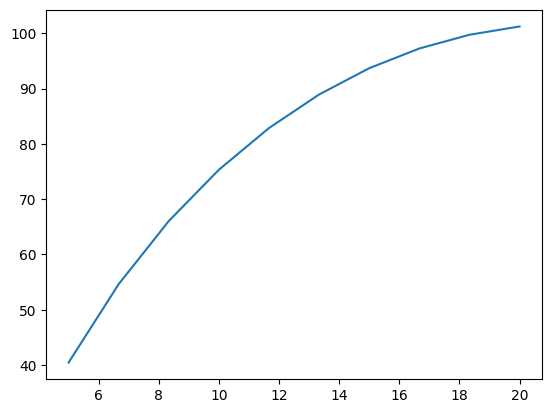

In [99]:
plt.plot(np.linspace(5,20,100), ct0(np.linspace(5,20,100)*MeV))

(0.0, 16.0)

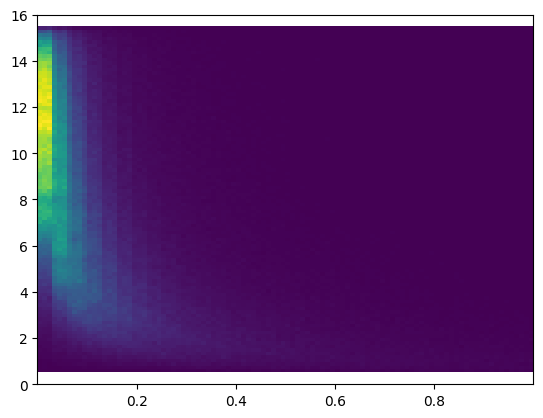

In [100]:
a,e = gr0(1_000_000,16*MeV)
e = e[a<1]
a = a[a<1]
plt.hist2d(a,e/MeV,bins=100)
plt.ylim([0,16])

(0.0, 16.0)

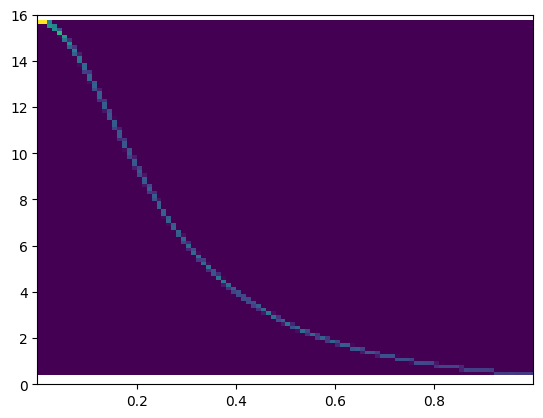

In [76]:
a,e = gen_cross_section_compton(
    19320000 / 196.97 * mol * 79, np.linspace(15, 17, 3) * MeV, np.linspace(0.0, np.pi, 1000)
)[1](1_000_000,16*MeV)
e = e[a<1]
a = a[a<1]
plt.hist2d(a,e/MeV,bins=100)
plt.ylim([0,16])

In [101]:
Z = 79
gold_number_density = 19320000 / 196.97 * mol


save_pairproduction_cross_section("gold_crosssection_pairproduction.npz",calculate_pairproduction_cross_section(
    Z,
    np.linspace(16,18,3)*MeV,
    np.linspace(0,1,100),
    np.linspace(0,np.pi,100),
    np.linspace(0,np.pi,100),
    np.linspace(0,2*np.pi,50),
))

building pair production cross section: 9.17% 	 1.0s/~10.9s  	now: 2025-06-23 17:50:13 .. end: 2025-06-23 17:50:23  [UTC-0400]
building pair production cross section: 18.45% 	 2.0s/~10.8s  	now: 2025-06-23 17:50:14 .. end: 2025-06-23 17:50:23  [UTC-0400]
building pair production cross section: 32.86% 	 3.5s/~10.7s  	now: 2025-06-23 17:50:16 .. end: 2025-06-23 17:50:23  [UTC-0400]
building pair production cross section: 54.47% 	 5.8s/~10.6s  	now: 2025-06-23 17:50:18 .. end: 2025-06-23 17:50:23  [UTC-0400]
building pair production cross section: 87.05% 	 9.1s/~10.5s  	now: 2025-06-23 17:50:21 .. end: 2025-06-23 17:50:23  [UTC-0400]
building pair production cross section: 100.0% 	 10.5s/~10.5s  	now: 2025-06-23 17:50:23 .. end: 2025-06-23 17:50:23  [UTC-0400]


array([1.11029157, 0.6069286 , 0.94800554, 0.5707816 , 0.36441525,
       0.35035602, 0.3949375 , 0.45020749, 0.55507343, 0.22108803,
       0.04957557, 0.30287816, 0.36349353, 0.14063921, 0.30388512,
       0.2508319 , 0.18753245, 1.2790118 , 0.10112987, 0.0710818 ,
       0.38200992, 1.12000639, 0.16010349, 1.06316808, 0.78369329,
       0.02838805, 0.12907884, 0.03135176, 0.30813243, 0.06265177,
       0.20613485, 0.29624912, 0.28232356, 0.22925982, 0.39873901,
       0.18159827, 1.29723475, 0.62100429, 0.34664152, 0.30191439,
       0.01577621, 0.18034997, 1.3628368 , 0.81345687, 0.15650188,
       0.14214436, 1.34317764, 1.1924177 , 0.14164487, 1.50025996,
       0.03773796, 0.04936728, 0.39720851, 0.02298166, 0.48778839,
       0.09102345, 0.20327485, 0.01194129, 0.16337998, 1.1745199 ,
       0.01654046, 0.70330324, 1.42481093, 0.42715955, 0.39979687,
       0.27276596, 0.53702211, 0.7268752 , 0.68102201, 0.06295609,
       0.19264405, 0.25108693, 0.30631633, 0.35474266, 0.55031

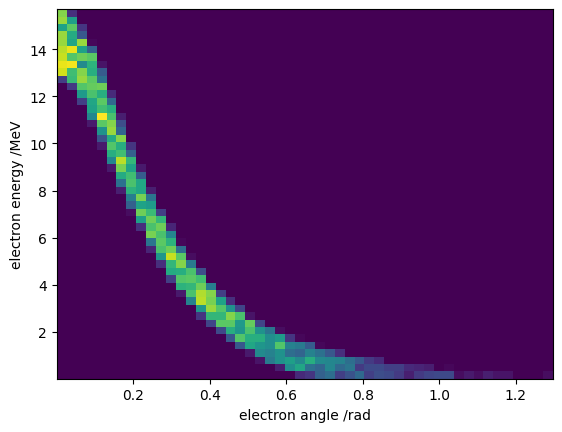

In [ ]:

with open("./edata.txt", "r") as srem:
    gold_srem = np.array(
        [[float(y) for y in x.split(" ")[:2]] for x in srem.readlines()[9:]]
    )
    gold_srem[:, 0] *= MeV  #  MeV  ->  J
    gold_srem[:, 1] *= 19.32 * 100 * MeV  #  MeV g / cm^3  ->  J / m
    gold_srem: SRXMData = gold_srem[:, 0], gold_srem[:, 1]


gold_crosssection_compton = gen_cross_section_compton(
    gold_number_density*Z, np.linspace(15, 17, 3) * MeV, np.linspace(0.0, np.pi, 1000)
)

gold_crosssection_pairproduction = gen_cross_section_pairproduction(
    gold_number_density, load_pairproduction_cross_section("gold_crosssection_pairproduction.npz")
)

def cross_section_total_test(x):
    return 50.0


def cross_section_differential_test(count: int, e_in: float) -> AngleEnergy:
    return np.zeros(count), e_in * np.ones(count)


cross_section_test: CrossSection = (
    cross_section_total_test,
    cross_section_differential_test,
)


gold_foil: Foil = gold_srem, [
    gold_crosssection_compton,
    gold_crosssection_pairproduction,
    # cross_section_test,
]

elec_angle, elec_energy = foil_trace(
    n_steps=1000,
    n_rays_incident=1_000_000,
    n_srxm_steps=100,
    phot_energy_in=16 * MeV,
    foil_properties=gold_foil,
    foil_depth=0.5 * millimeter,
)

# plt.scatter(elec_angle, elec_energy / MeV, s=1)
plt.hist2d(elec_angle[elec_energy>0], elec_energy[elec_energy>0] / MeV, bins=50)
plt.xlabel("electron angle /rad")
plt.ylabel("electron energy /MeV")
# plt.xlim(-0.1,np.pi)
# plt.ylim(0,17)
elec_angle[:1000]

Text(0, 0.5, 'electron energy /MeV')

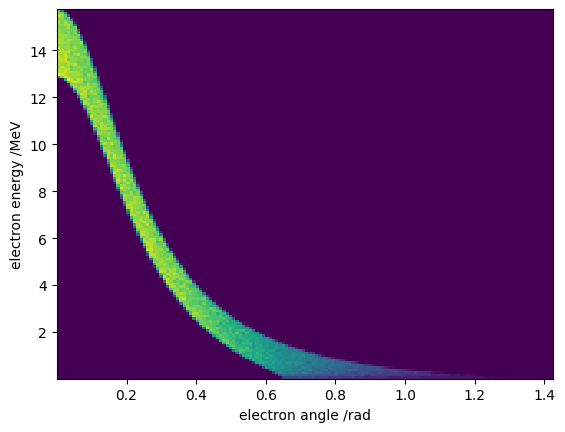

In [26]:

plt.hist2d(elec_angle[elec_energy>0], elec_energy[elec_energy>0] / MeV, bins=150)
plt.xlabel("electron angle /rad")
plt.ylabel("electron energy /MeV")

((np.float64(0.0001333217229573489), np.float64(3.078348774243886)),
 (np.float64(0.0009789796830512695), np.float64(1.5686424059957158)))

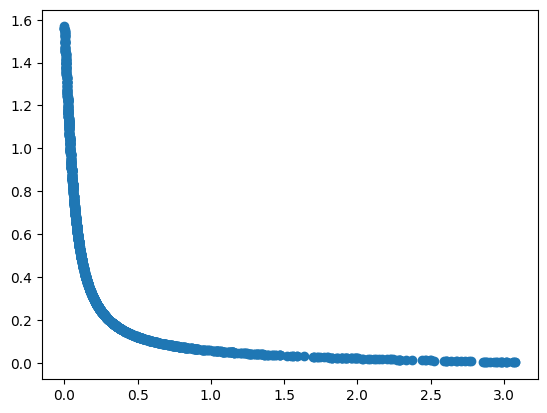

In [15]:
VVB = (np.array([x for x in VB for x in x]).flatten())
VVC = (np.array([x for x in VC for x in x]).flatten())
plt.scatter(VVB,VVC)
(VVB.min(), VVB.max()), (VVC.min(), VVC.max())
# AJKA.min()/MeV, AJKA.max()/MeV